# Input

In [1]:
import os
import pandas as pd
import yaml
import torch
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
DATASET_PARAMS = yaml.load(open("configs/uc_infeksi/dataset.yaml"), Loader=yaml.SafeLoader)
PREPROCESSING_PARAMS = yaml.load(open("configs/uc_infeksi/preprocessing.yaml"), Loader=yaml.SafeLoader)
MODEL_NAME = yaml.load(open("configs/uc_infeksi/model.yaml"), Loader=yaml.SafeLoader)['MODEL_NAME']
MODEL_PARAMS = yaml.load(open("configs/uc_infeksi/model.yaml"), Loader=yaml.SafeLoader)[MODEL_NAME]
TRAINING_PARAMS = yaml.load(open("configs/uc_infeksi/training.yaml"), Loader=yaml.SafeLoader)

In [3]:
categories =  DATASET_PARAMS['CATEGORIES']

BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, DATASET_PARAMS['DATA_PATH'])

TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")
TEST_DIR = os.path.join(DATASET_DIR, "test")

In [4]:
from src.utils import get_device, set_seed

set_seed(DATASET_PARAMS['SEED'])
DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: cuda


# Dataset

In [5]:
from src.utils import split_dataset

In [6]:
train_filenames_df, val_filenames_df, test_filenames_df = split_dataset(DATASET_DIR, 
                                                                        categories, 
                                                                        DATASET_PARAMS['UC_SOURCE'], 
                                                                        shuffle=DATASET_PARAMS['IS_SHUFFLE'], 
                                                                        seed=DATASET_PARAMS['SEED'], 
                                                                        split_ratio=DATASET_PARAMS['SPLIT_RATIO'])

subdirectories: ['infeksi', 'uc']
subdirectory: infeksi
subdirectory: uc
subdirectory: infeksi\infeksi_non_spesifik
subdirectory: uc\changsu
subdirectory: uc\hyperkvasir
subdirectory: uc\limuc
subdirectory: uc\limuc_cropped
subdirectory: uc\changsu\uc_1
subdirectory: uc\changsu\uc_2
subdirectory: uc\changsu\uc_3
subdirectory: uc\hyperkvasir\uc_1
subdirectory: uc\hyperkvasir\uc_2
subdirectory: uc\hyperkvasir\uc_3
subdirectory: uc\limuc\uc_1
subdirectory: uc\limuc\uc_2
subdirectory: uc\limuc\uc_3


In [7]:
from src.preprocessing import preprocess

target_input_size = tuple(PREPROCESSING_PARAMS['INPUT_SIZE'])
train_transform = preprocess(
    target_input_size=target_input_size,
    rotation_range=PREPROCESSING_PARAMS['ROTATION_RANGE'],
    width_shift_range=PREPROCESSING_PARAMS['WIDTH_SHIFT_RANGE'],
    height_shift_range=PREPROCESSING_PARAMS['HEIGHT_SHIFT_RANGE'],
    brightness_range=PREPROCESSING_PARAMS['BRIGHTNESS_RANGE'],
    zoom_range=PREPROCESSING_PARAMS['ZOOM_RANGE'],
    horizontal_flip=PREPROCESSING_PARAMS['HORIZONTAL_FLIP'],
    vertical_flip=PREPROCESSING_PARAMS['VERTICAL_FLIP'],
    channel_shift_range=PREPROCESSING_PARAMS['CHANNEL_SHIFT_RANGE'],
    fill_mode=PREPROCESSING_PARAMS['FILL_MODE'],
    shear_range=PREPROCESSING_PARAMS['SHEAR_RANGE']
    )

val_transform = preprocess(target_input_size=target_input_size) # only rescaling

In [8]:
from src.dataset import Dataset

train_dataset = Dataset(dataframe=train_filenames_df, 
                        categories=DATASET_PARAMS['CATEGORIES'],
                        transform=train_transform, 
                        seed=42, 
                        shuffle=False)

val_dataset = Dataset(dataframe=val_filenames_df, 
                      categories=DATASET_PARAMS['CATEGORIES'],
                      transform=val_transform, 
                      seed=42, 
                      shuffle=False)

test_dataset = Dataset(dataframe=test_filenames_df, 
                      categories=DATASET_PARAMS['CATEGORIES'],
                      transform=val_transform, 
                      seed=42, 
                      shuffle=False)

## Train loader

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, 
                          batch_size=TRAINING_PARAMS['BATCH_SIZE'], 
                          shuffle=False, 
                          num_workers=TRAINING_PARAMS['NUM_WORKERS'])

val_loader = DataLoader(val_dataset, 
                          batch_size=TRAINING_PARAMS['BATCH_SIZE'], 
                          shuffle=False, 
                          num_workers=TRAINING_PARAMS['NUM_WORKERS'])

#if test_dataset exist
if test_dataset:
    test_loader = DataLoader(test_dataset, 
                             batch_size=TRAINING_PARAMS['BATCH_SIZE'], 
                             shuffle=False, 
                             num_workers=TRAINING_PARAMS['NUM_WORKERS'])

In [10]:
from src.utils import load_model

model = load_model("artifacts/densenet121/epoch_24.pth", num_classes=2, dropout_rate=0.25)
model = model.to(DEVICE)

In [11]:
num_classes = len(categories)
# metrics
from torcheval.metrics import (
    BinaryAccuracy,
    BinaryF1Score,
    BinaryPrecision,
    BinaryAUROC,
    BinaryRecall    
)

test_metrics = {
    "binary_auroc": BinaryAUROC(device=DEVICE),
    "accuracy": BinaryAccuracy(device=DEVICE),
    "f1_score": BinaryF1Score(device=DEVICE),
    "precision": BinaryPrecision(device=DEVICE),
    "recall": BinaryRecall(device=DEVICE),
}

In [12]:
from src.xdl import plot_XDL_GradCAM

plot_XDL_GradCAM(model = model, 
                 test_loader = test_loader, 
                 device = DEVICE, 
                 print_img = False, 
                 num_samples = len(test_loader.dataset.dataframe), 
                 save_path = "outputs/gradcam_revised/limuc_cropped_novasir",
                 fontsize = 14)

Processed 8 samples
Processed 88 samples
Processed 168 samples
Processed 248 samples
Processed 328 samples
Processed 408 samples


In [12]:
from src.test import test

raw_predictions, predicted_indices_flattened, target_indices_flattened,test_metrics = test(model = model, test_loader= test_loader, device = DEVICE, metrics=test_metrics)
test_metrics

Testing:   0%|          | 0/56 [00:00<?, ?it/s]

Testing: 100%|██████████| 56/56 [00:23<00:00,  2.43it/s]


{'binary_auroc': 0.8763697419582891,
 'accuracy': 0.8247190713882446,
 'f1_score': 0.7577639818191528,
 'precision': 0.6130653023719788,
 'recall': 0.9918699264526367}

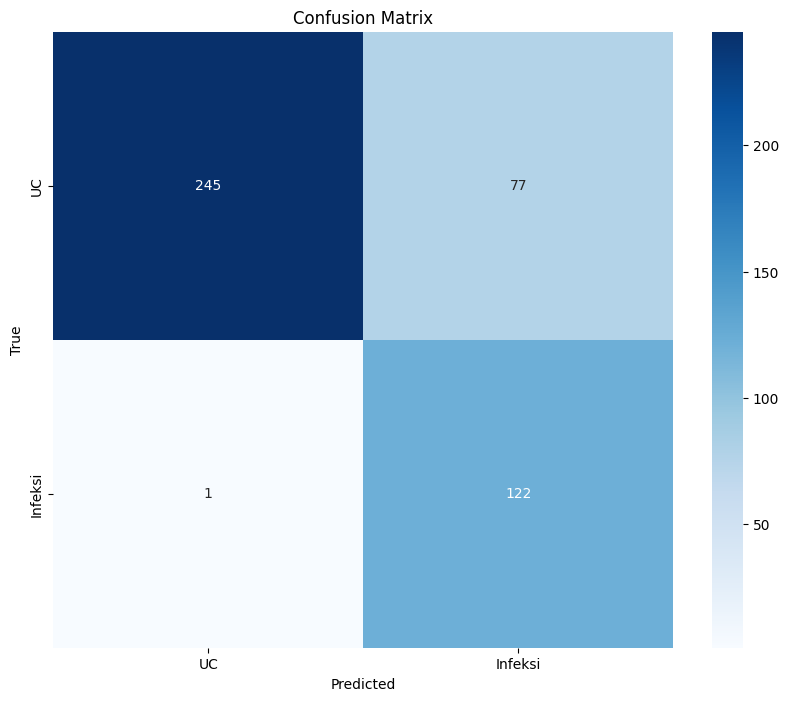

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Calculate confusion matrix
cm = confusion_matrix(target_indices_flattened, predicted_indices_flattened)

# Create figure and axis
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['UC', 'Infeksi'],
            yticklabels=['UC', 'Infeksi'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show plot
plt.show()